In [6]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

In [7]:
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import argparse
import imutils
import time
import dlib


def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])

    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3])

    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C)

    # return the eye aspect ratio
    return ear

In [29]:
class ClosedEyesChecker:
    def __init__(
        self,
        img_folder: str,
        output_file: str,
        path_dlib_predictor: str = "./weights/shape_predictor_68_face_landmarks.dat",
        path_cv2_face: str = "./weights/haarcascade_frontalface_alt.xml",
        path_cv2_eyes: str = "./weights/haarcascade_eye_tree_eyeglasses.xml",
    ):
        self.dlib_detector = dlib.get_frontal_face_detector()
        self.dlib_predictor = dlib.shape_predictor(path_dlib_predictor)

        self.lStart, self.lEnd = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
        self.rStart, self.rEnd = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
        
        self.asians_ids = ['P_01', 'P_02', 'P_07', 'P_14', 'P_15', 'P_24', 'P_29', 'P_34',
                           'P_37', 'P_47', 'P_53', 'P_57', 'P_58', 'P_60', 'P_63', 'P_64',
                           'P_17', 'P_20', 'P_27', 'P_44', 'P_45', 'P_56', 'P_54', 'P_39','P_35']
        self.img_paths = glob.glob(os.path.join(img_folder, "*.png"))
        self.img_folder = img_folder
        self.EYE_AR_THRESH = {
            "asian": 0.24,
            "not_asian": 0.3,
        }
        
        self.faceCascade = cv2.CascadeClassifier(path_cv2_face)
        self.eyeCascade = cv2.CascadeClassifier(path_cv2_eyes)
        self.output_file = output_file
        with open(self.output_file, "w") as f:
            f.write("")
            
    def __check_race(self, img_path: str):
        img_name = img_path.replace(self.img_folder, "")
        user_id = "_".join(img_name.split("_")[:2])
        return user_id in self.asians_ids
    
    
    def check_closed_eyes_dlib(
        self,
        file_path: str,
        gray_frame: np.ndarray,
        color_frame: np.ndarray,
        plot = False,
    ):
        rects = self.dlib_detector(gray_frame, 0)
        for rect in rects:
            shape = self.dlib_predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            leftEye = shape[self.lStart:self.lEnd]
            rightEye = shape[self.rStart:self.rEnd]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)

            # average the eye aspect ratio together for both eyes
            ear = (leftEAR + rightEAR)

            # compute the convex hull for the left and right eye, then
            # visualize each of the eyes
            if plot:
                leftEyeHull = cv2.convexHull(leftEye)
                rightEyeHull = cv2.convexHull(rightEye)
                cv2.drawContours(color_frame, [leftEyeHull], -1, (0, 255, 0), 1)
                cv2.drawContours(color_frame, [rightEyeHull], -1, (0, 255, 0), 1)

            # check to see if the eye aspect ratio is below the blink
            # threshold, and if so, increment the blink frame counter
            person_race = "asian" if self.__check_race(file_path) else "not_asian"
            if ear < self.EYE_AR_THRESH[person_race]:
                with open(self.output_file, "a") as f:
                    f.write(file_path + "\n")
                if plot:
                    cv2.putText(color_frame, "Eye: {}".format("Close"), (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                    cv2.putText(color_frame, "EAR: {:.2f}".format(ear), (300, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            else:
                if plot:
                    cv2.putText(frame, "Eye: {}".format("Open"), (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                    cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        return color_frame, len(rects)
    
    def check_closed_eyes_cv2(
        self,
        file_path: str,
        gray_frame: np.ndarray,
        color_frame: np.ndarray,
        plot = False,
    ):
        faces = self.faceCascade.detectMultiScale(
            gray_frame,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30),
        )
        if len(faces) > 0:
            # Draw a rectangle around the faces
            if plot:
                for (x, y, w, h) in faces:
                    cv2.rectangle(color_frame, (x, y), (x + w, y + h), (0, 255, 0), 2) 
            color_frame = color_frame[faces[0][1]:faces[0][1] + faces[0][3], faces[0][0]:faces[0][0] + faces[0][2]:1, :]
            gray_frame = gray_frame[faces[0][1]:faces[0][1] + faces[0][3], faces[0][0]:faces[0][0] + faces[0][2]:1]
            eyes = self.eyeCascade.detectMultiScale(
                gray_frame,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30),
            )
            if len(eyes) == 0:
                with open(self.output_file, "a") as f:
                    f.write(file_path + "\n")
            else:
                if plot:
                    for (x, y, w, h) in eyes:
                        cv2.rectangle(color_frame, (x, y), (x + w, y + h), (255, 0, 0), 1)
        else:
            eyes = self.eyeCascade.detectMultiScale(
                gray_frame,
                scaleFactor=1.1,
                minNeighbors=5,
                minSize=(30, 30),
            )
            if len(eyes) == 0:
                with open(self.output_file, "a") as f:
                    f.write(file_path + "\n")
            else:
                for (x, y, w, h) in eyes:
                    cv2.rectangle(color_frame, (x, y), (x + w, y + h), (255, 0, 0), 1)
                    
        return color_frame

In [9]:
img_folder = "../data/tobii_images/"
checker = ClosedEyesChecker(
    img_folder = img_folder,
    output_file = "./closed_eyes.txt",
)
plot = False
num_samples = None

In [10]:
for i, img_path in tqdm(
    enumerate(checker.img_paths[:num_samples]),
    total = len(checker.img_paths[:num_samples])
):
    try:
        frame = cv2.imread(img_path)
    except:
        print(img_path)
        continue
    frame = imutils.resize(frame, width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame, num_faces_detected = checker.check_closed_eyes_dlib(
        file_path = img_path,
        gray_frame = gray,
        color_frame = frame,
        plot = plot,
    )
    if num_faces_detected == 0:
        frame = checker.check_closed_eyes_cv2(
            file_path = img_path,
            gray_frame = gray,
            color_frame = frame,
            plot = plot,
        )
        
    if plot:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()

 15%|████▊                          | 114894/748864 [1:28:24<8:29:29, 20.74it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [12]:
with open("./closed_eyes.txt", "r") as f:
    st = f.read().strip(" \n")

In [13]:
img_noeyes = st.split("\n")

In [15]:
len(img_noeyes)

16932

## Test found images

In [27]:
random_inds = np.random.randint(0, len(img_noeyes) - 1, 20)

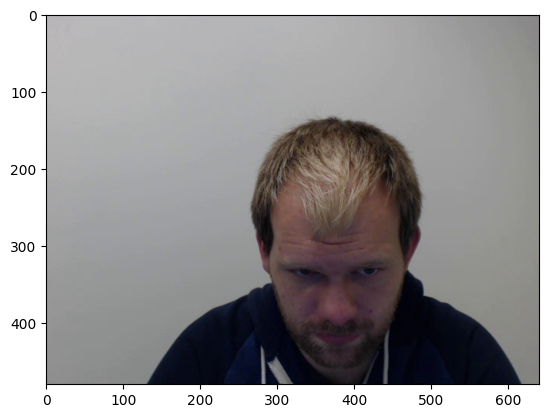

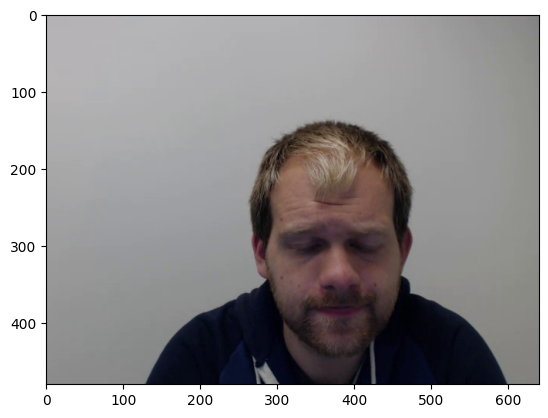

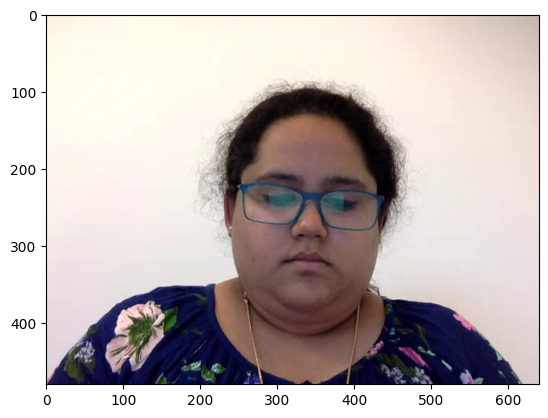

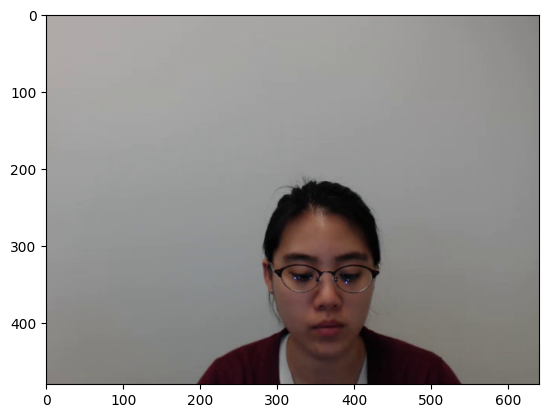

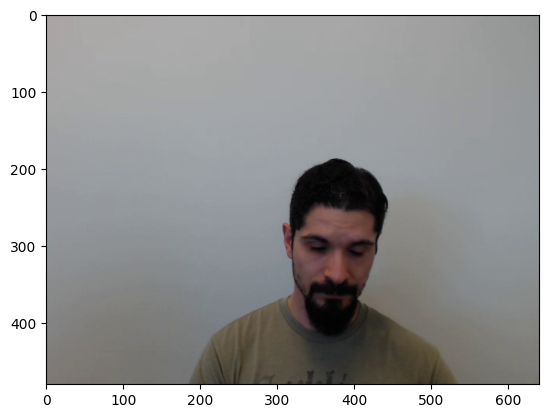

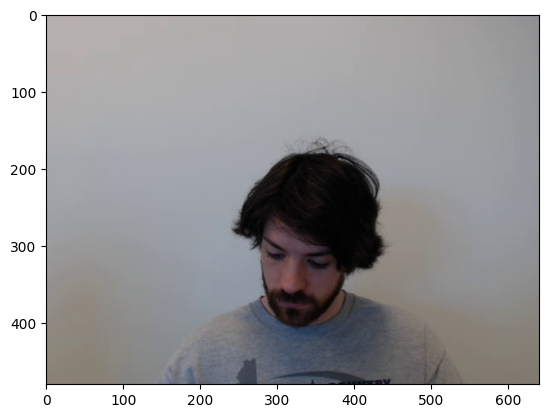

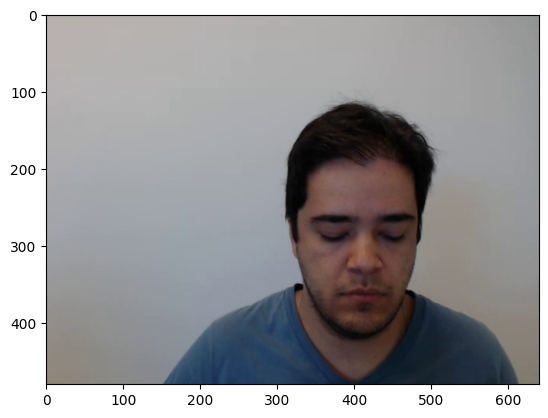

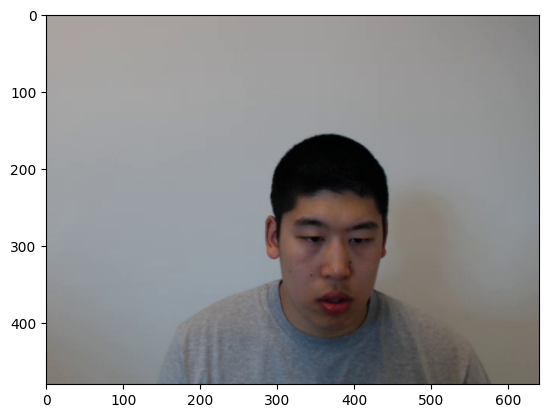

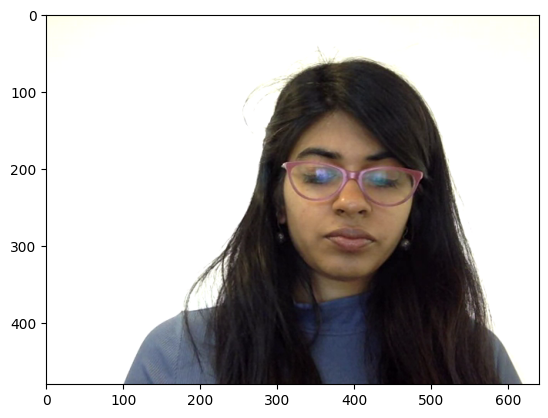

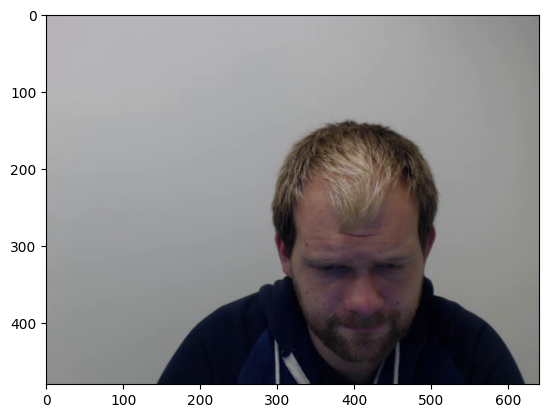

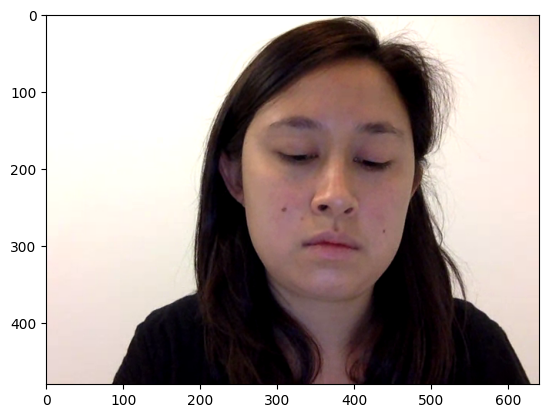

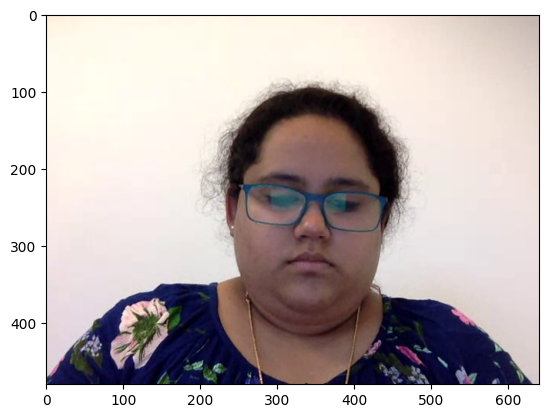

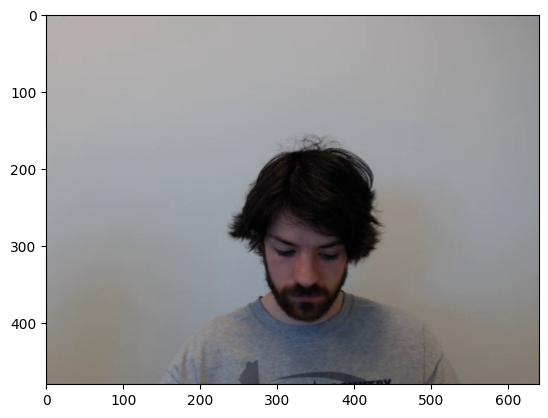

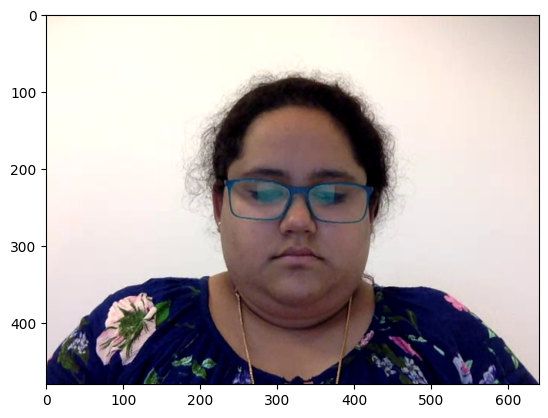

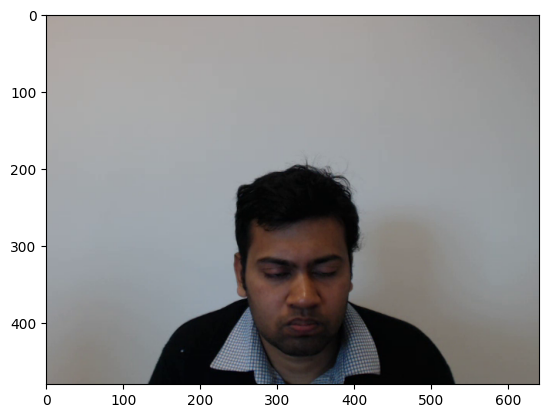

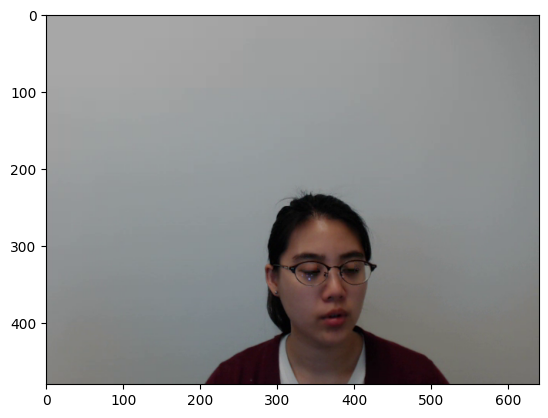

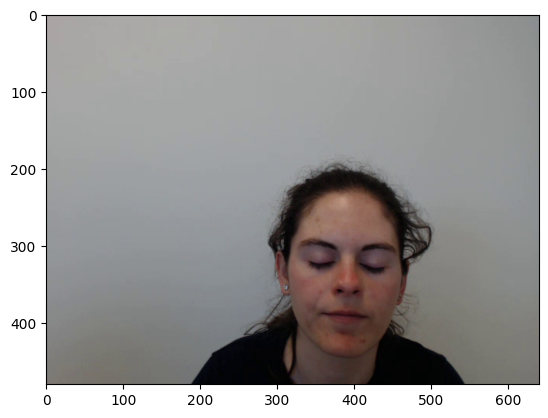

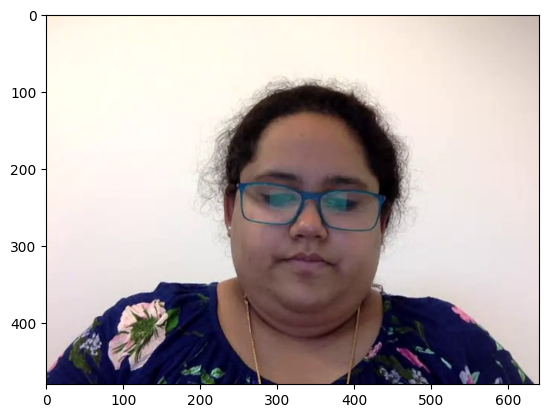

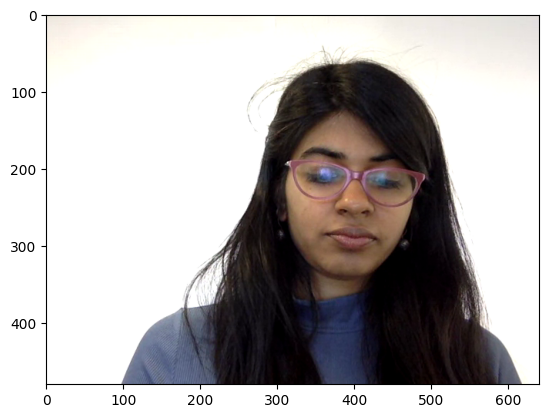

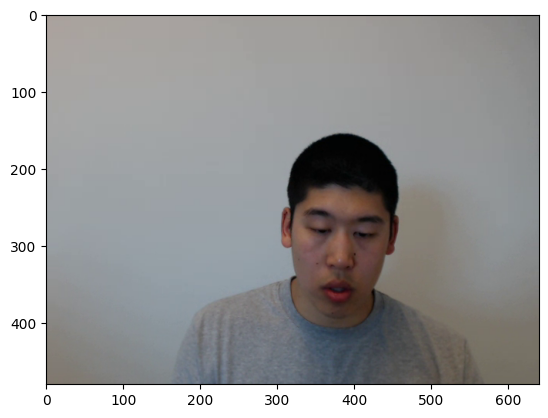

In [28]:
for i in random_inds:
    frame = cv2.imread(img_noeyes[i])
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    plt.imshow(frame)
    plt.show()

Quite a lot of mistakes

In [30]:
img_folder = "../data/tobii_images/"
checker = ClosedEyesChecker(
    img_folder = img_folder,
    output_file = "./closed_eyes_upd.txt",
)
plot = False
num_samples = None

In [31]:
checker.img_paths = img_noeyes

In [32]:
for i, img_path in tqdm(
    enumerate(checker.img_paths[:num_samples]),
    total = len(checker.img_paths[:num_samples])
):
    try:
        frame = cv2.imread(img_path)
    except:
        print(img_path)
        continue
    frame = imutils.resize(frame, width=450)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame, num_faces_detected = checker.check_closed_eyes_dlib(
        file_path = img_path,
        gray_frame = gray,
        color_frame = frame,
        plot = plot,
    )
    if num_faces_detected == 0:
        frame = checker.check_closed_eyes_cv2(
            file_path = img_path,
            gray_frame = gray,
            color_frame = frame,
            plot = plot,
        )
        
    if plot:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.show()

100%|█████████████████████████████████████| 16932/16932 [12:35<00:00, 22.42it/s]


In [33]:
with open("./closed_eyes_upd.txt", "r") as f:
    st = f.read().strip(" \n")

In [34]:
img_noeyes_upd = st.split("\n")

In [35]:
len(img_noeyes_upd)

10326

In [61]:
error_users = ["P_02", "P_38", "P_10", "P_59"]

In [67]:
img_noeyes_upd_cleaned = []
for path in img_noeyes_upd:
    id = path.split("/")[-1].split("#")[0]
    if id not in error_users:
        img_noeyes_upd_cleaned.append(path)

In [68]:
len(img_noeyes_upd_cleaned)

7890

## Test found images

In [36]:
df = pd.read_csv("./data_tobii_names.csv")

In [71]:
random_inds = np.random.randint(0, len(img_noeyes_upd_cleaned) - 1, 20)

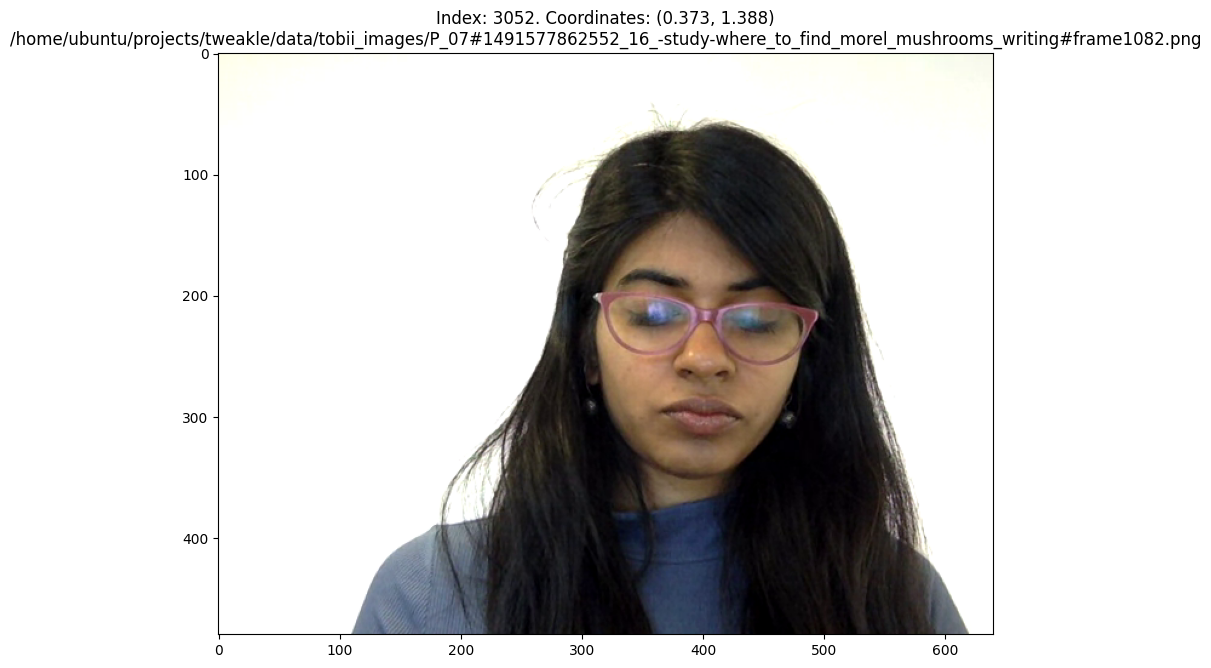

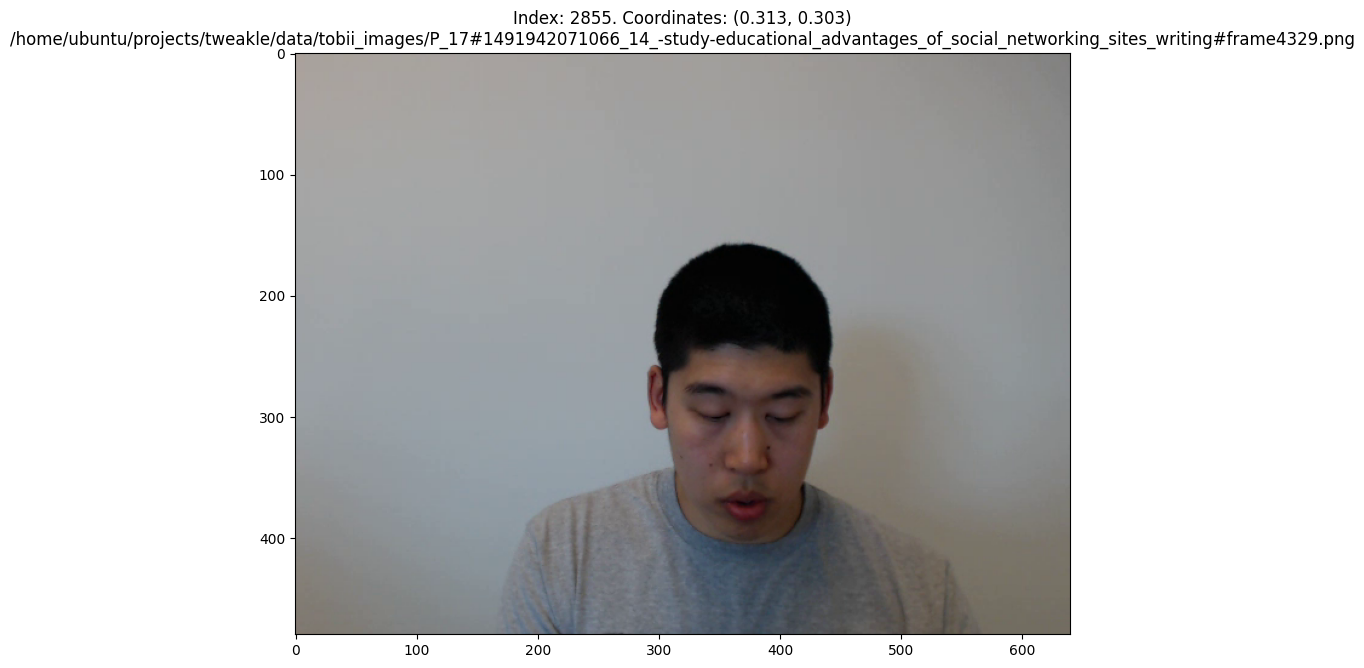

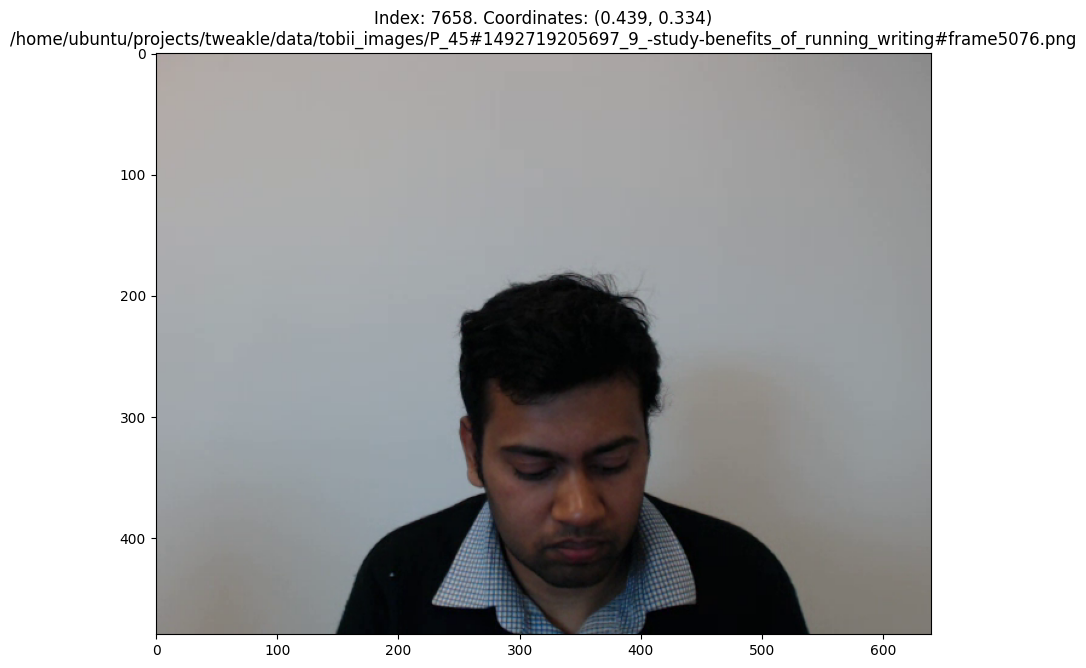

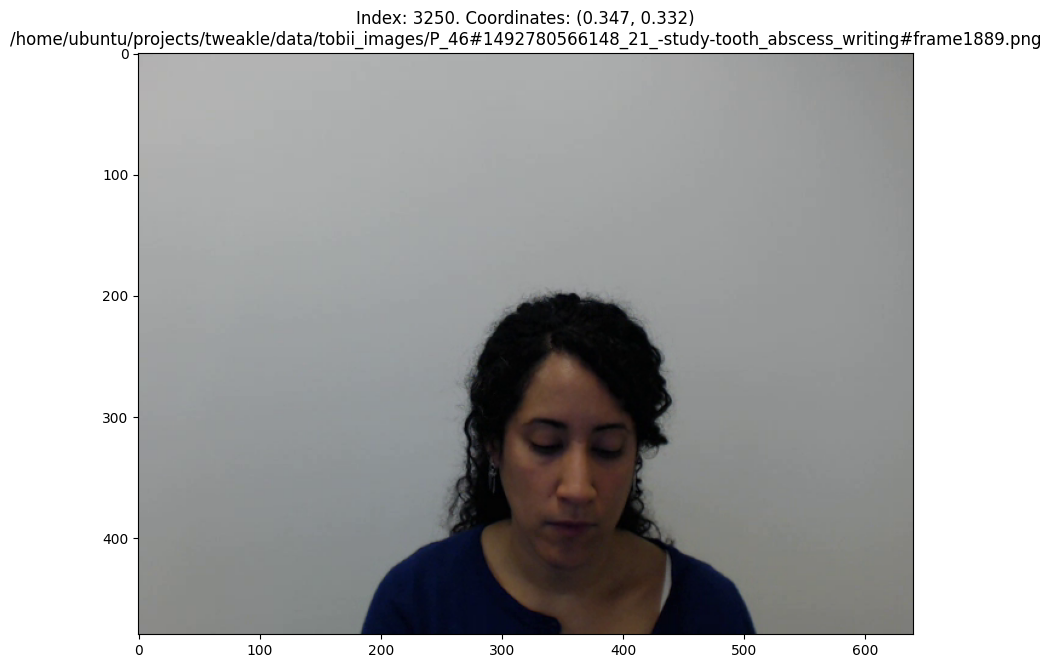

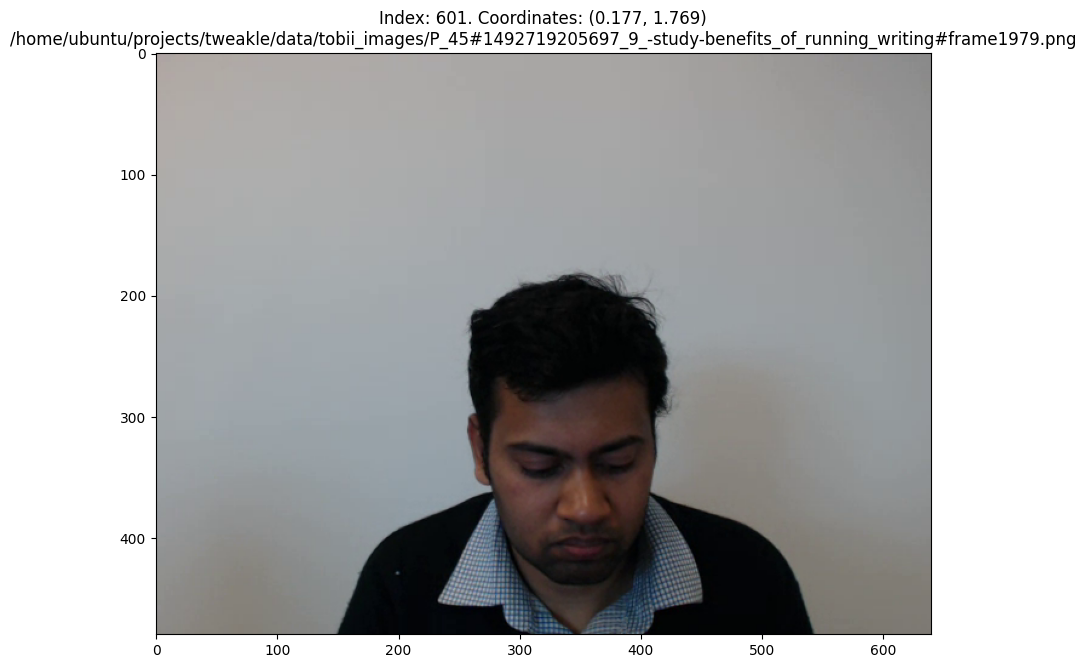

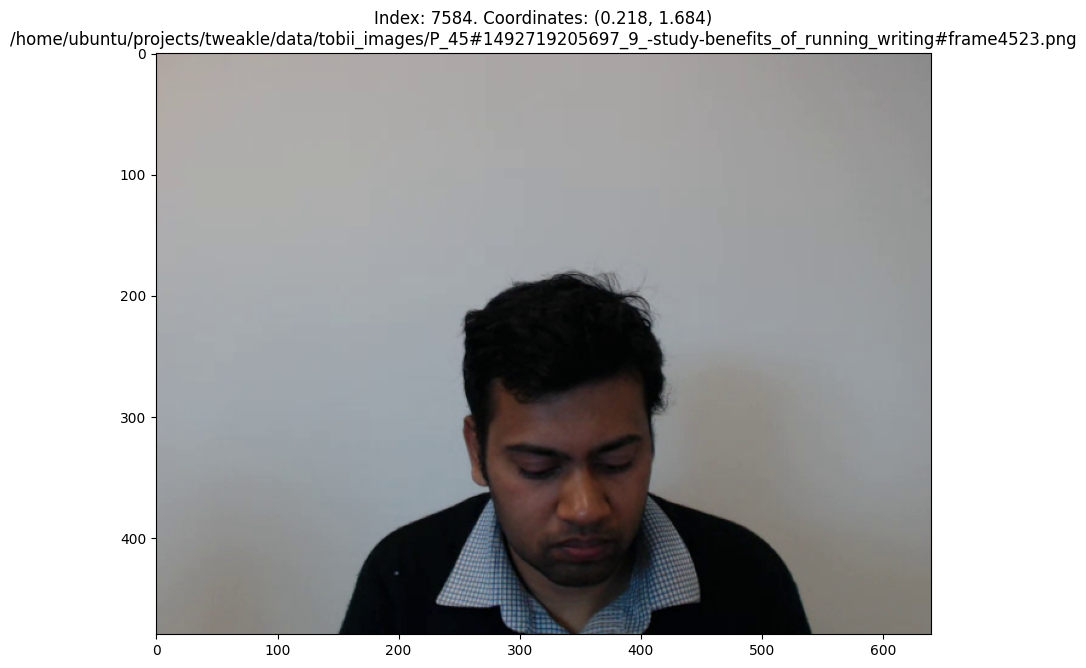

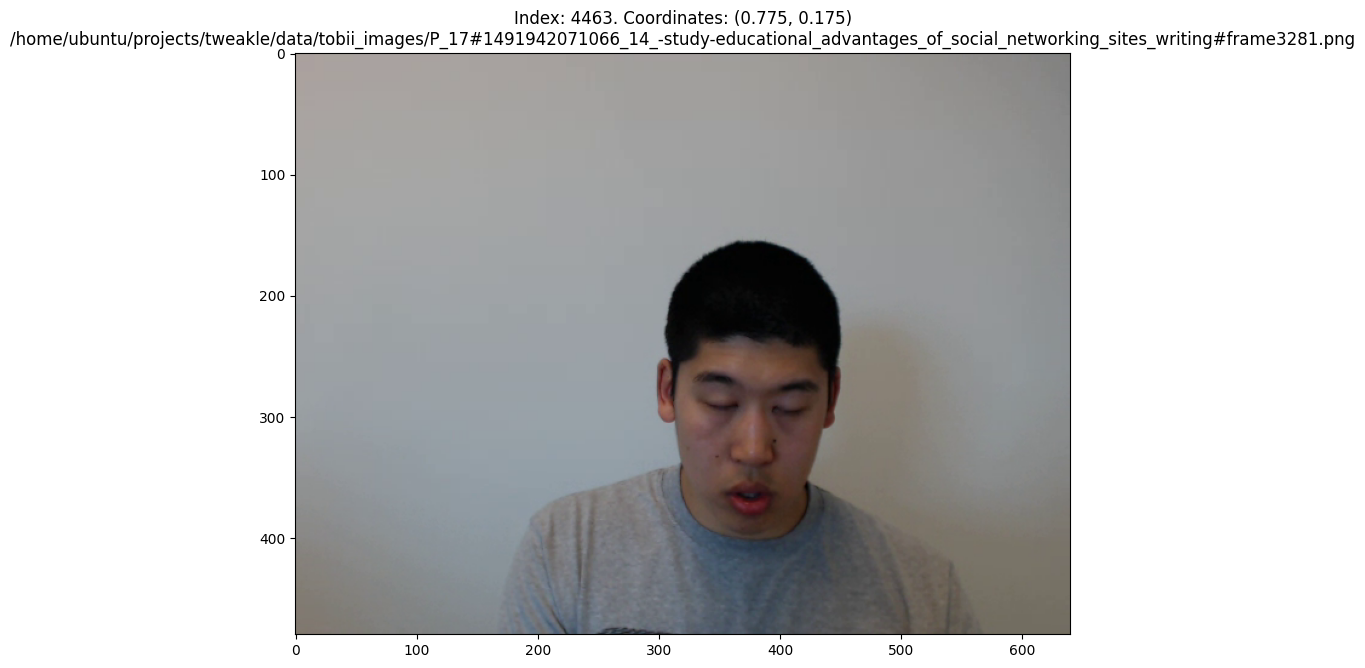

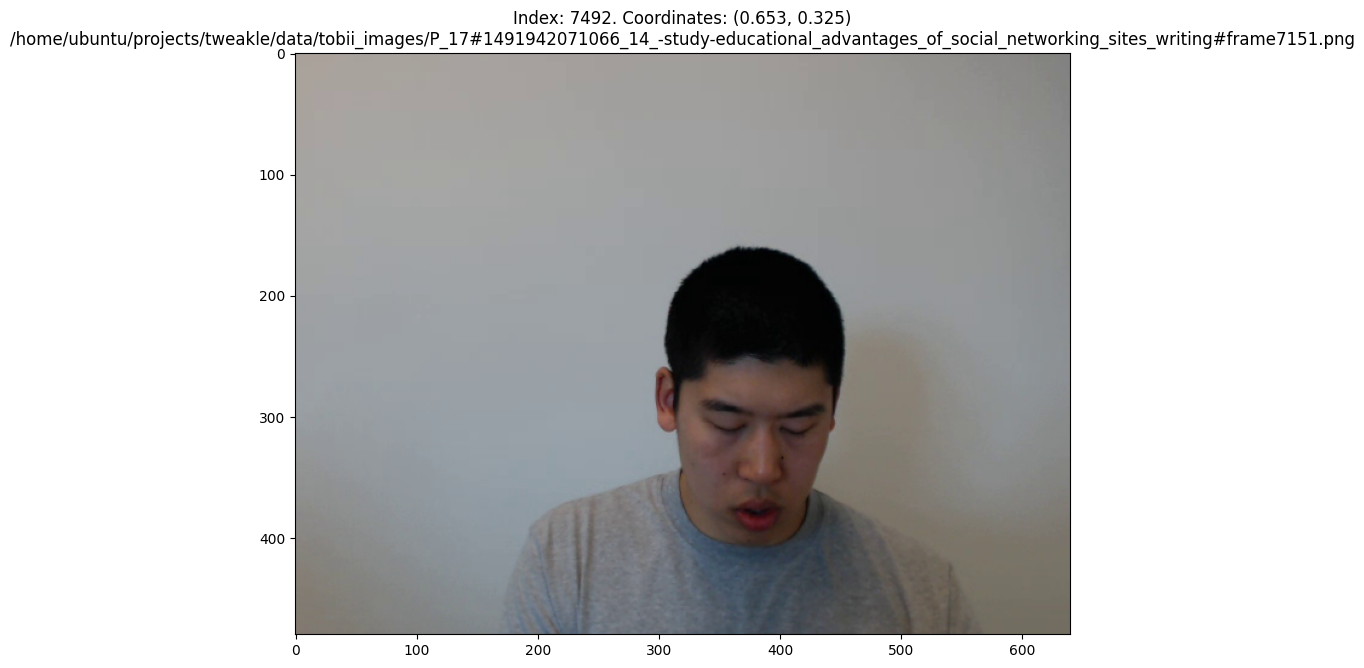

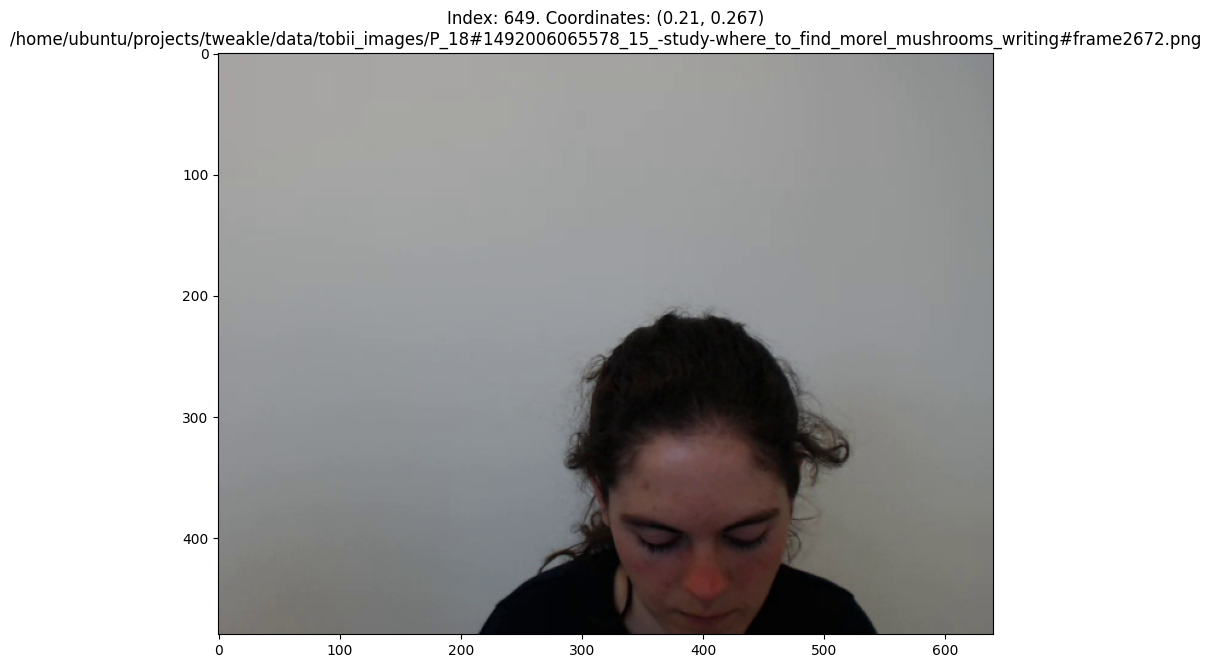

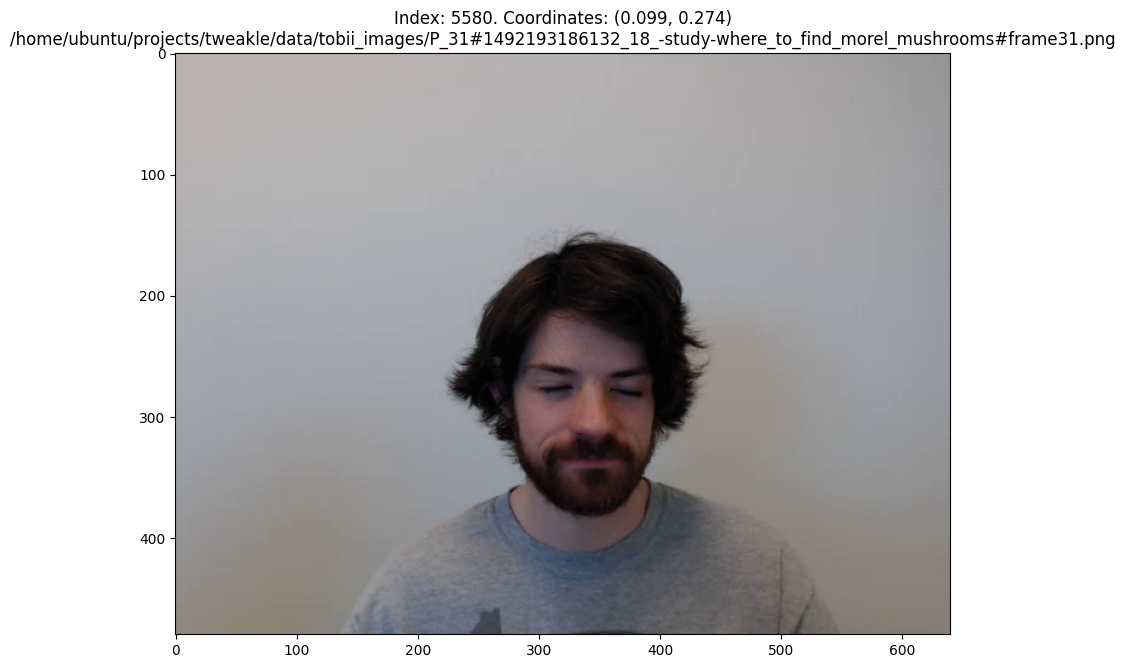

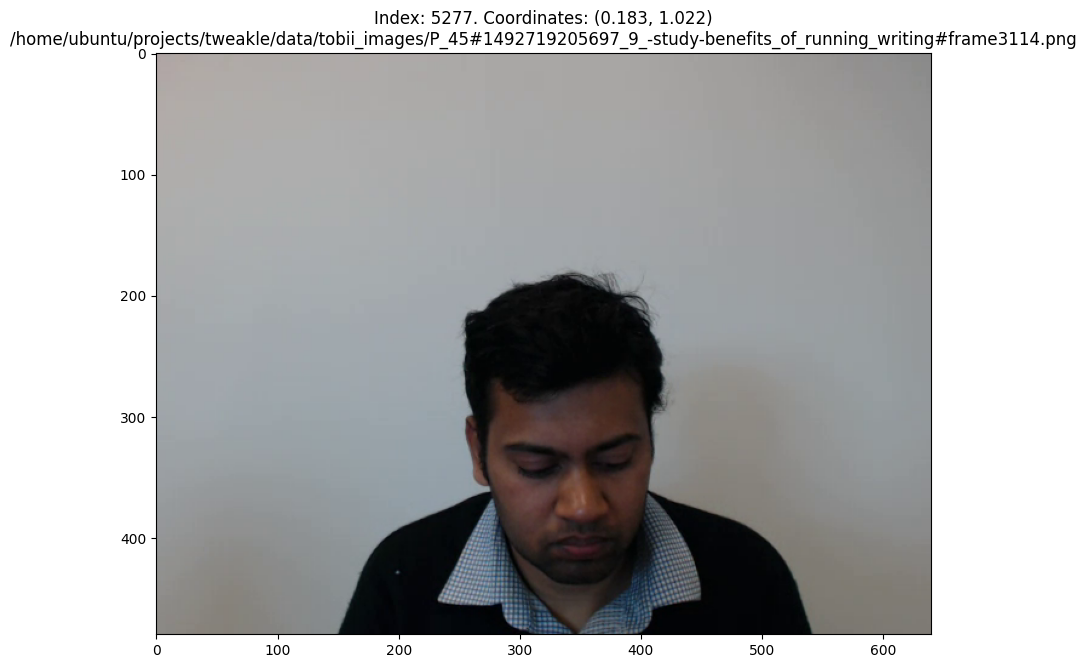

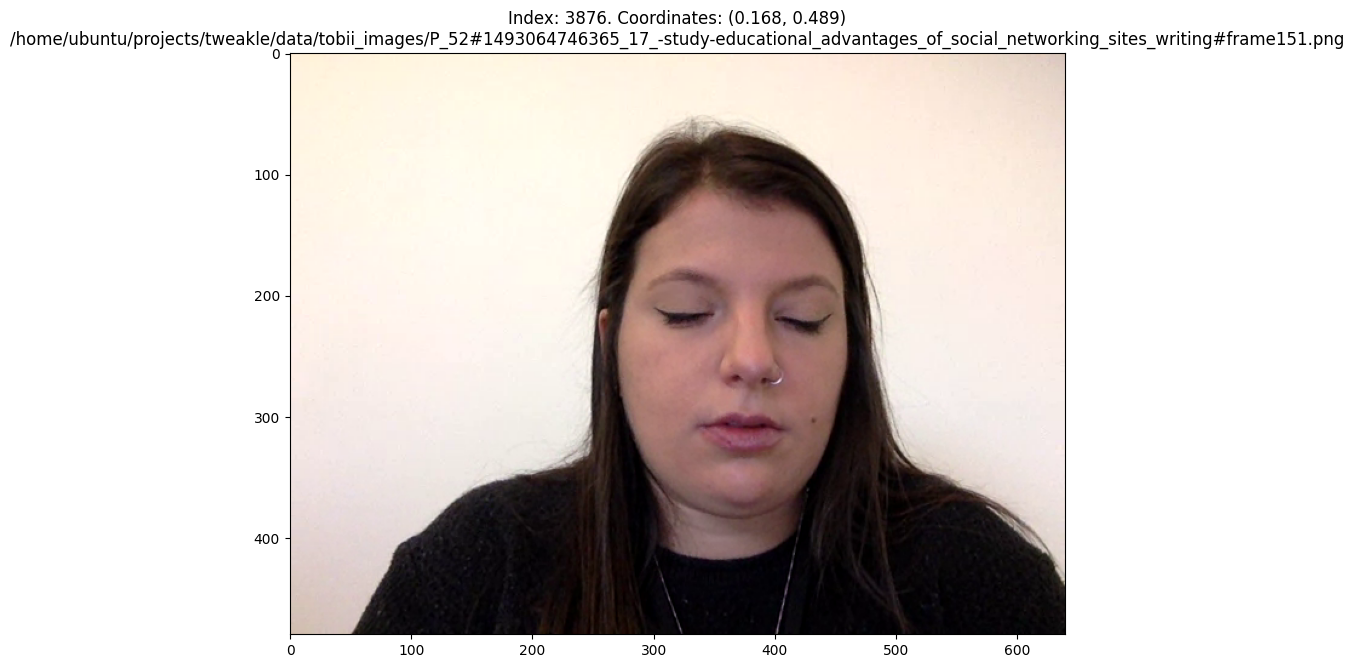

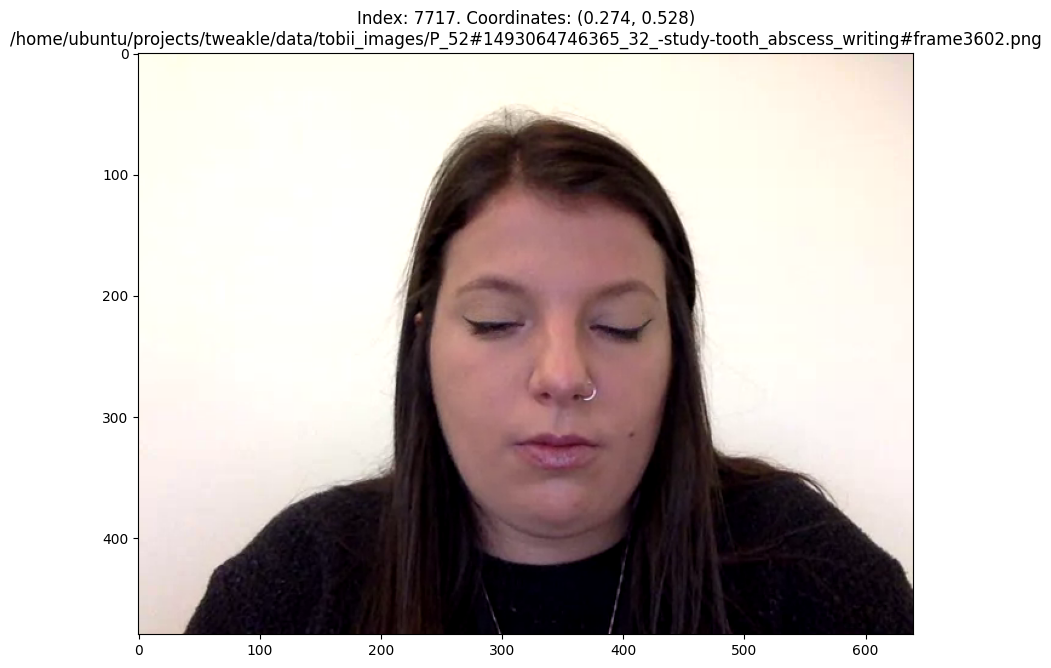

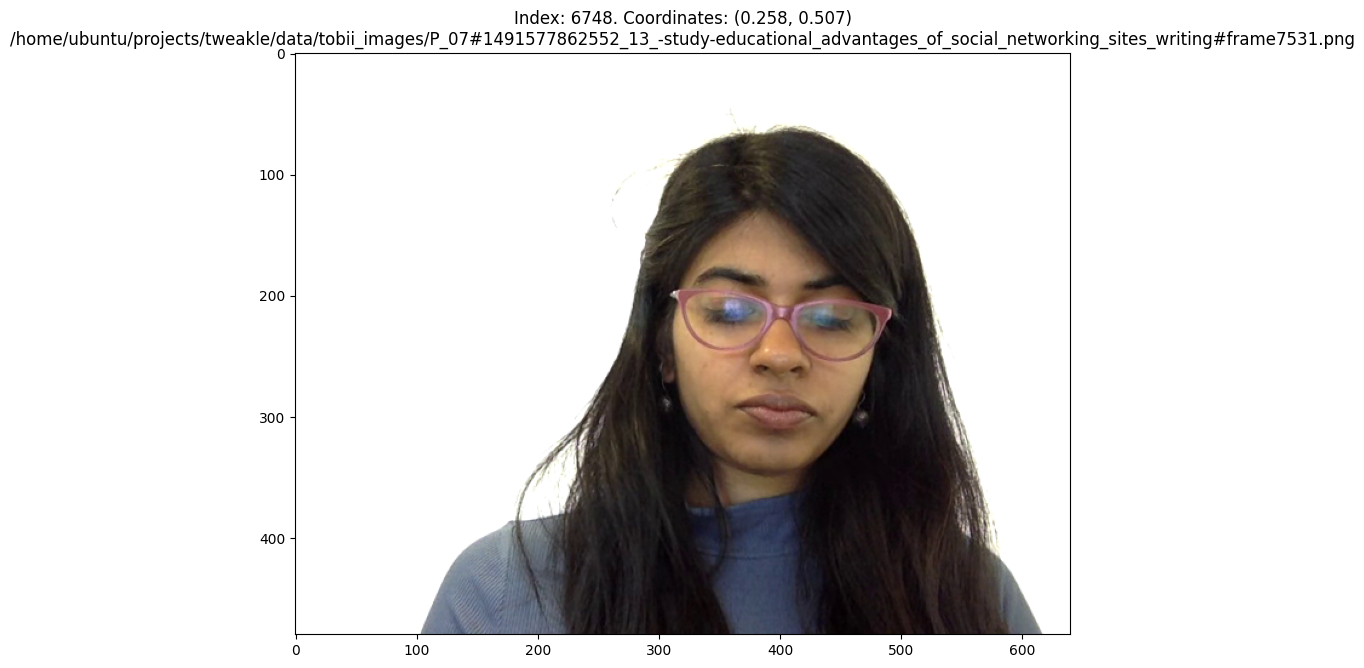

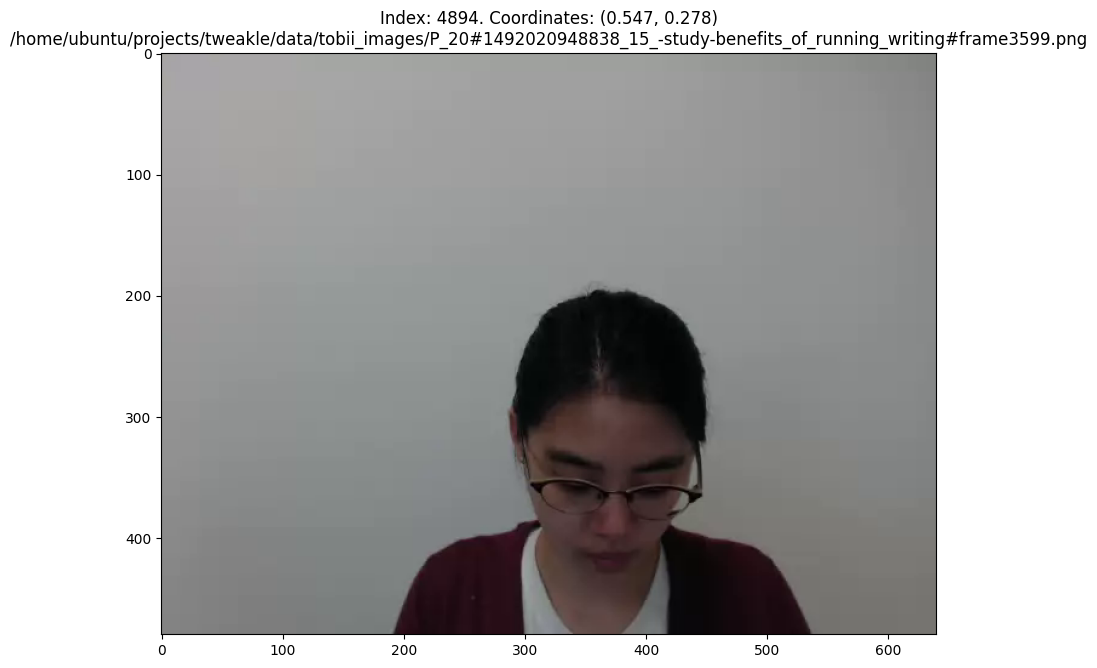

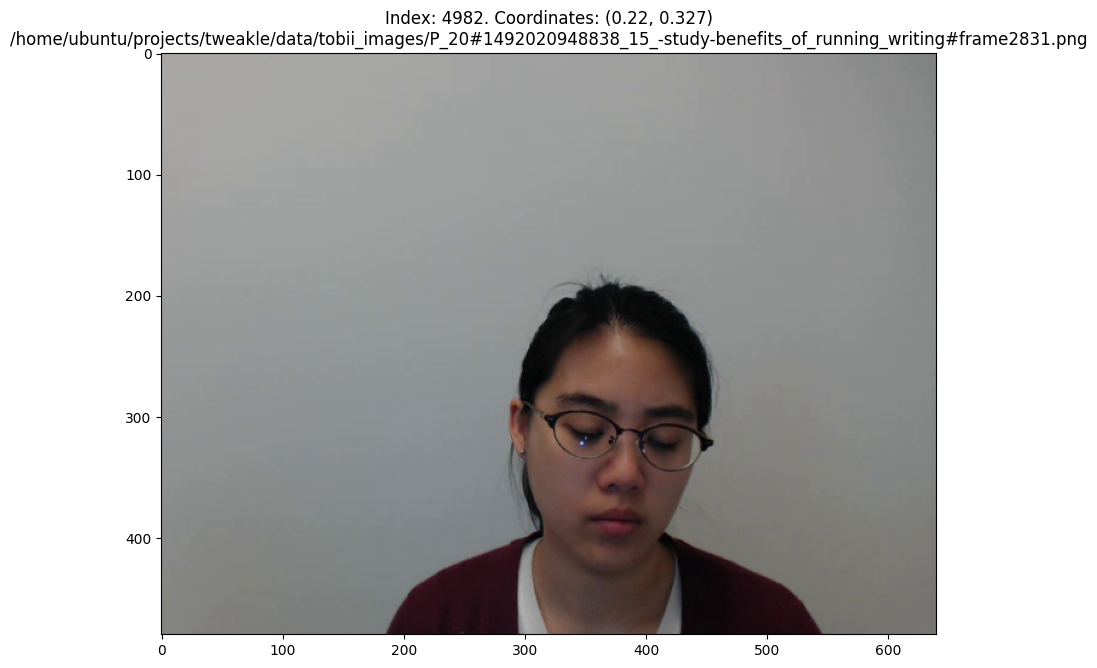

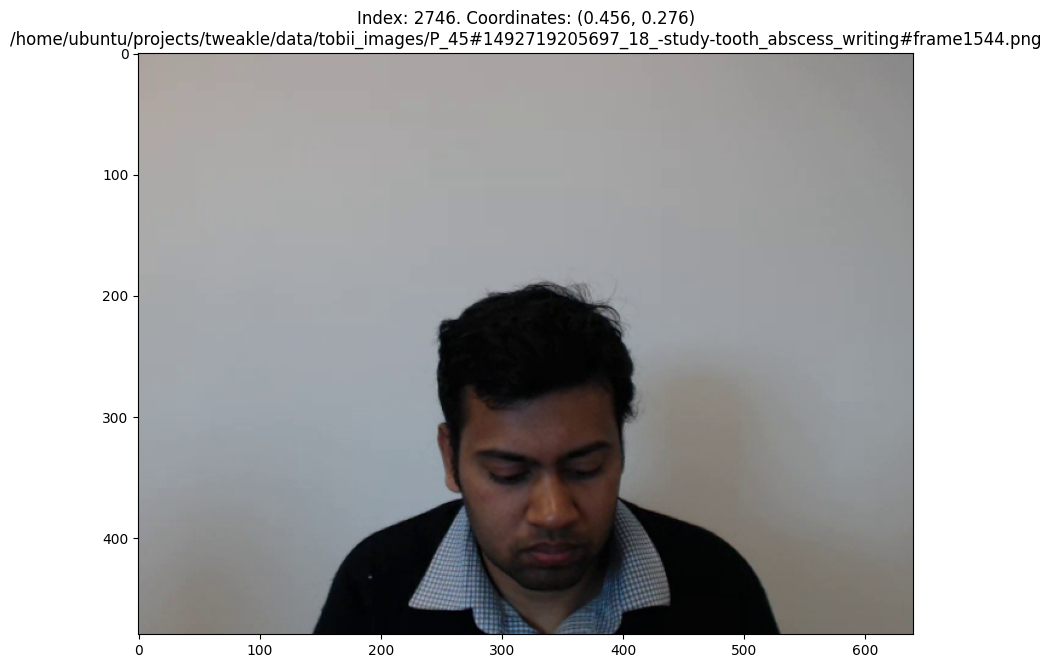

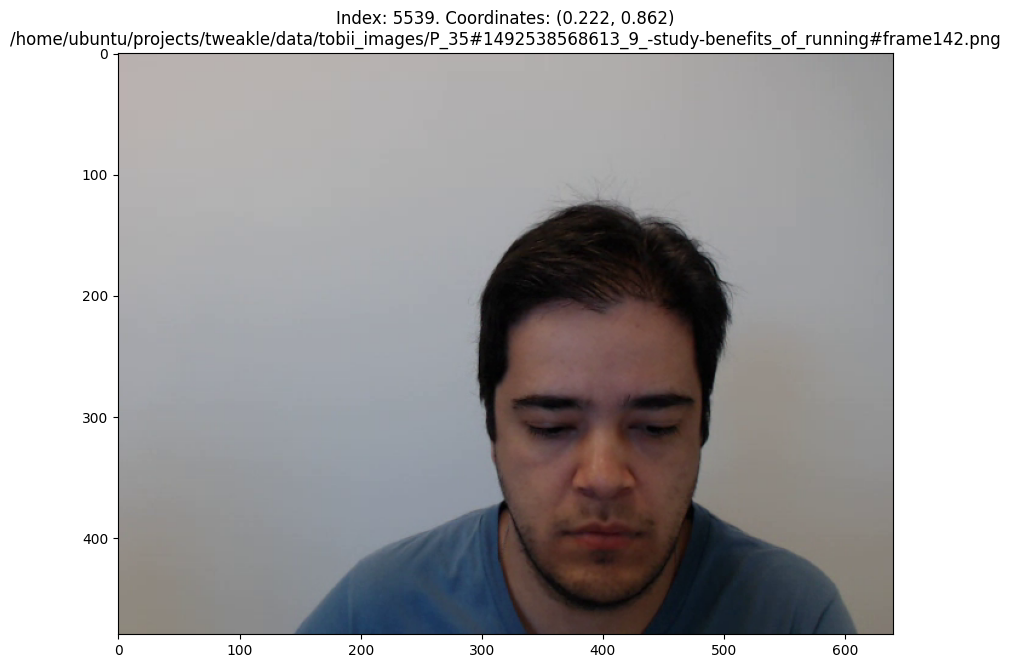

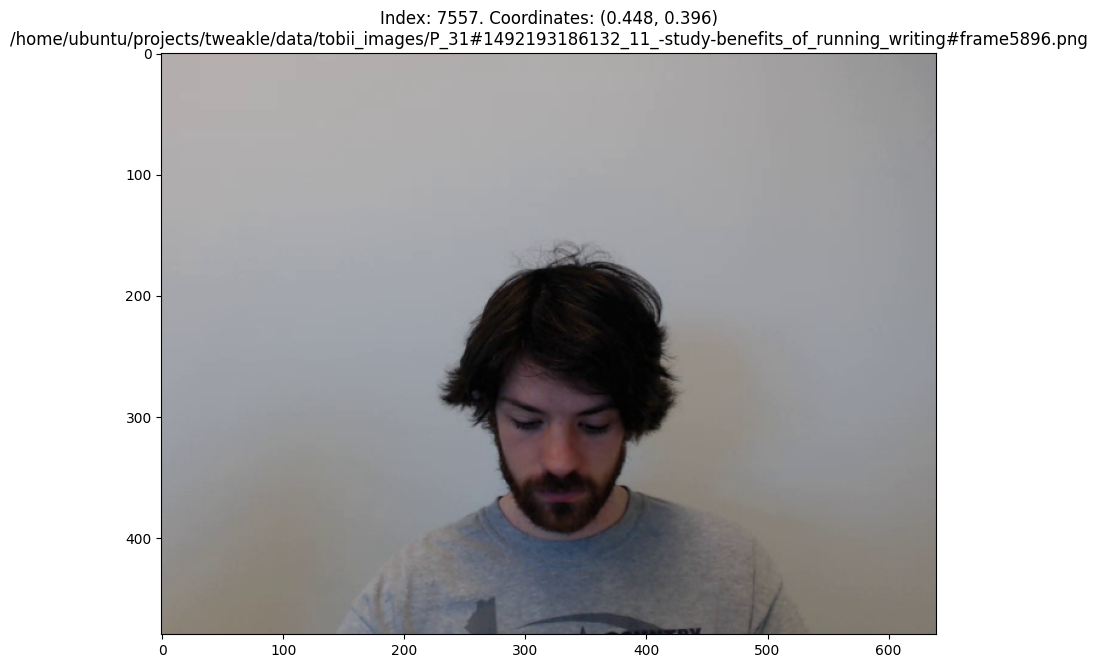

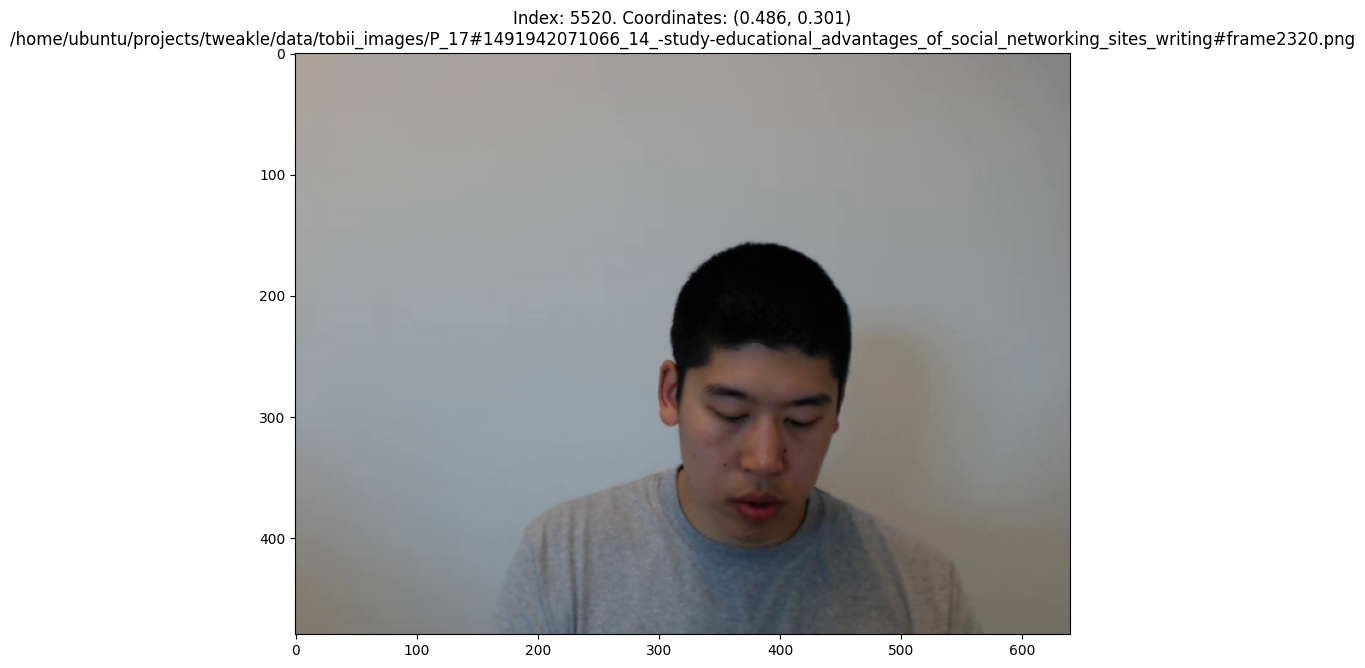

In [72]:
for index_test in random_inds:
    abs_path = "/home/ubuntu/projects/tweakle/" + img_noeyes_upd_cleaned[index_test][3:]
    row = df[df["paths"] == abs_path].iloc[0]
    path = row['paths']
    img = cv2.imread(img_noeyes_upd_cleaned[index_test])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.title(f'Index: {index_test}. Coordinates: ({round(row["x_normalized"],3)}, {round(row["y_normalized"],3)})\n{row["paths"]}')
    plt.imshow(img)
    plt.show()

In [76]:
test_df = pd.read_csv("./tobii_test_sub.csv")
val_df = pd.read_csv("./tobii_val_sub.csv")
train_df = pd.read_csv("./tobii_train_sub.csv")

In [96]:
val_df.shape

(8500, 4)

In [87]:
from typing import List
def update_coordinates(input_df: pd.DataFrame, error_paths: List[str]):
    df = input_df.copy()
    num_changed = 0
    for path in tqdm(error_paths):
        abs_path = "/home/ubuntu/projects/tweakle/" + path[3:]
        df_tmp = df[df["paths"] == abs_path]
        if df_tmp.shape[0] > 0:
            row = df_tmp.iloc[0]
            index_change = df_tmp.index[0]
            if row["y_normalized"] < 1.0:
                df.at[index_change, 'y_normalized'] = 1.5
                num_changed += 1
    return df, num_changed

In [88]:
train_df_upd, num_changed = update_coordinates(train_df, img_noeyes_upd_cleaned)
num_changed

100%|██████████████████████████████████████| 7890/7890 [00:53<00:00, 147.41it/s]


702

In [91]:
train_df_upd.shape

(76500, 4)

In [92]:
val_df_upd, num_changed = update_coordinates(val_df, img_noeyes_upd_cleaned)
num_changed

100%|██████████████████████████████████████| 7890/7890 [00:08<00:00, 970.38it/s]


87

In [93]:
val_df_upd.shape

(8500, 4)

In [94]:
test_df_upd, num_changed = update_coordinates(test_df, img_noeyes_upd_cleaned)
num_changed

100%|██████████████████████████████████████| 7890/7890 [00:12<00:00, 617.67it/s]


161

In [95]:
test_df_upd.shape

(15000, 4)

In [97]:
test_df_upd.to_csv("./tobii_test_sub_upd.csv", index = False)
val_df_upd.to_csv("./tobii_val_sub_upd.csv", index = False)
train_df_upd.to_csv("./tobii_train_su_upd.csv", index = False)